In [ ]:
### Goal of this notebook is to get acquainted with the data set, test its plausibility and find first correlations in the data.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

,year,win_percentage,win_percentage_vs_top10,avg_aces,avg_double_faults,break_point_save_ratio,2nd_serve_win_percentage,return_win_percentage,ATP_titles
0,2015,0.451613,0.000000,6.548387,4.451613,0.593295,0.481591,0.332930,0
1,2016,0.647059,0.400000,6.514706,4.544118,0.644773,0.514082,0.383937,1
2,2017,0.714286,0.500000,8.415584,3.558442,0.677874,0.542961,0.376460,5
3,2018,0.753247,0.571429,7.636364,2.961039,0.623432,0.540179,0.405149,4
4,2019,0.632353,0.300000,10.558824,5.794118,0.621503,0.461858,0.387530,1
5,2020,0.717949,0.333333,10.820513,5.641026,0.627496,0.467445,0.395663,2
6,2021,0.772727,0.555556,10.545455,3.969697,0.605348,0.528034,0.402804,4
7,2022,0.743590,0.375000,7.230769,3.692308,0.651433,0.494460,0.395034,0
8,2023,0.670732,0.222222,7.926829,2.890244,0.652559,0.500855,0.378085,2
9,2024,0.772727,0.533333,9.318182,2.102273,0.741951,0.574443,0.384187,3


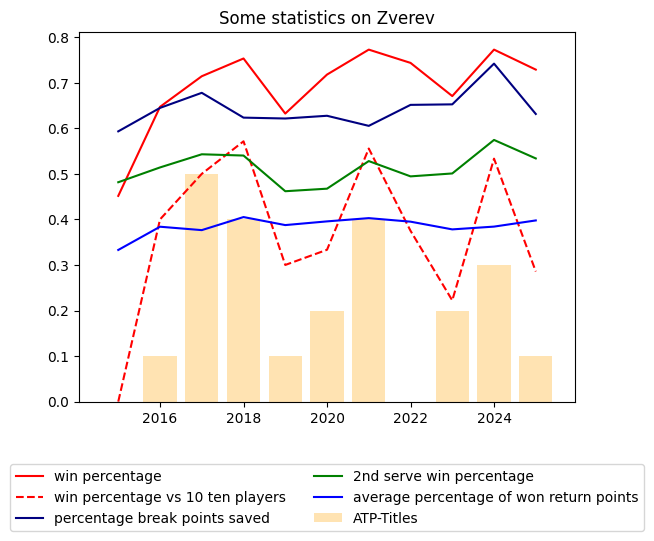

In [ ]:
### Refactored yearly statistics for Zverev

# Use a list of disctionaries to store results
yearly_stats_list = []

for year in range(2015,2026):
    #Load data and handle exception
    ## INSERT YOUR FILEPATH HERE
    file_path = f'../tennis_data/ATP_data/{year}.csv'
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        continue # Skip if the year's file doesn't exist

    #Clean data
    numeric_cols = ['w_ace', 'l_ace', 'w_df', 'l_df', 'w_bpSaved', 'l_bpSaved', 'w_bpFaced', 'l_bpFaced',
                    'w_1stIn', 'l_1stIn', 'w_1stWon', 'l_1stWon', 'w_2ndWon', 'l_2ndWon', 'w_svpt', 'l_svpt',
                    'winner_rank', 'loser_rank']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(subset=numeric_cols, inplace=True) # Drop rows where essential stats are missing

    #Create unified data frame for Zverev
    player_df = df[df['winner_name'].str.contains('alexander zverev', case=False, na=False) | 
                   df['loser_name'].str.contains('alexander zverev', case=False, na=False)].copy()
    
    if player_df.empty:
        continue         #Skip year if no matches are recorded
    
    ### Create new columns
    player_df['is_win'] = np.where(player_df['winner_name'].str.contains('alexander zverev', case=False, na=False), 1, 0)
    player_df['aces'] = np.where(player_df['is_win'] == 1, player_df['w_ace'], player_df['l_ace'])
    player_df['double_faults'] = np.where(player_df['is_win'] == 1, player_df['w_df'], player_df['l_df'])
    player_df['bp_saved'] = np.where(player_df['is_win'] == 1, player_df['w_bpSaved'], player_df['l_bpSaved'])
    player_df['bp_faced'] = np.where(player_df['is_win'] == 1, player_df['w_bpFaced'], player_df['l_bpFaced'])
    player_df['bp_ratio'] = np.where(player_df['bp_faced'] > 0, player_df['bp_saved']/player_df['bp_faced'], 1)
    player_df['opponent_rank'] = np.where(player_df['is_win'] == 1, player_df['loser_rank'], player_df['winner_rank'])
    
    # Second Serve Win %
    svpt = np.where(player_df['is_win'] == 1, player_df['w_svpt'], player_df['l_svpt'])
    first_in = np.where(player_df['is_win'] == 1, player_df['w_1stIn'], player_df['l_1stIn'])
    second_won = np.where(player_df['is_win'] == 1, player_df['w_2ndWon'], player_df['l_2ndWon'])
    player_df['2nd_serve_win_pc'] = second_won / (svpt - first_in)
    
    # Return Points Won %
    opp_svpt = np.where(player_df['is_win'] == 1, player_df['l_svpt'], player_df['w_svpt'])
    opp_1st_won = np.where(player_df['is_win'] == 1, player_df['l_1stWon'], player_df['w_1stWon'])
    opp_2nd_won = np.where(player_df['is_win'] == 1, player_df['l_2ndWon'], player_df['w_2ndWon'])
    player_df['return_win_pc'] = (opp_svpt - opp_1st_won - opp_2nd_won) / opp_svpt

    ### Calculate all aggregations from the clean DataFrame
    total_matches = len(player_df)
    win_percentage = player_df['is_win'].mean() # The mean of a 0/1 column is the percentage of 1s!
    titles = player_df[(player_df['is_win'] == 1) & (player_df['round'] == 'F')].shape[0]

    # vs. Top 10
    top10_matches_df = player_df[player_df['opponent_rank'] <= 10]
    win_percent_vs_top10 = top10_matches_df['is_win'].mean() if not top10_matches_df.empty else 0

    # Breakpoint save ratio
    bp_save_ratio = player_df['bp_ratio'].mean()

    # Store results
    yearly_stats_list.append({
        'year': year,
        'win_percentage': win_percentage,
        'win_percentage_vs_top10': win_percent_vs_top10,
        'avg_aces': player_df['aces'].mean(),
        'avg_double_faults': player_df['double_faults'].mean(),
        'break_point_save_ratio': bp_save_ratio,
        '2nd_serve_win_percentage': player_df['2nd_serve_win_pc'].mean(),
        'return_win_percentage': player_df['return_win_pc'].mean(),
        'ATP_titles': titles
    })

### Convert final list to a DataFrame for easy plotting
stats_df = pd.DataFrame(yearly_stats_list)
display(stats_df)

plt.plot(stats_df['year'], stats_df['win_percentage'], color = 'red', label = 'win percentage')
plt.plot(stats_df['year'], stats_df['win_percentage_vs_top10'], color='red', linestyle = 'dashed', label = 'win percentage vs 10 ten players')
plt.plot(stats_df['year'], stats_df['break_point_save_ratio'], color = 'navy', label = 'percentage break points saved')
plt.plot(stats_df['year'], stats_df['2nd_serve_win_percentage'], color = 'green', label = '2nd serve win percentage')
plt.plot(stats_df['year'], stats_df['return_win_percentage'], color = 'blue', label = 'average percentage of won return points')
plt.bar(stats_df['year'], 0.1*stats_df['ATP_titles'], label='ATP-Titles', color='orange', alpha=0.3)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
plt.title('Some statistics on Zverev')
plt.show()

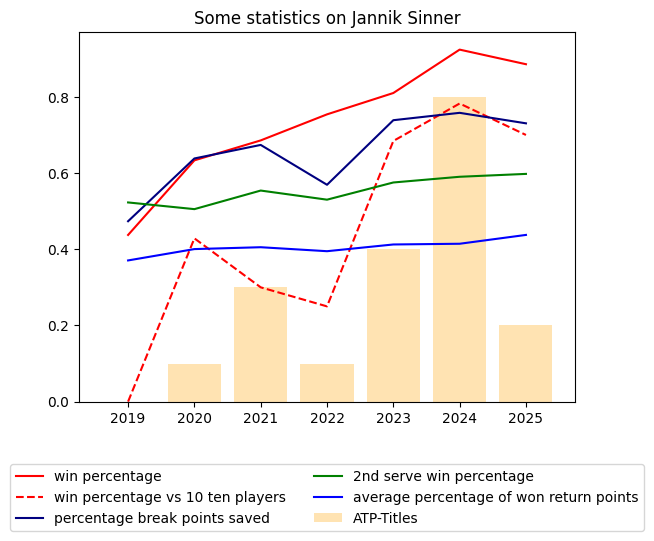

/var/folders/39/p2xs9v7547vfxg9djk82zf3c0000gn/T/ipykernel_25899/542252706.py:47: RuntimeWarning: invalid value encountered in divide
  player_df['2nd_serve_win_pc'] = second_won / (svpt - first_in)


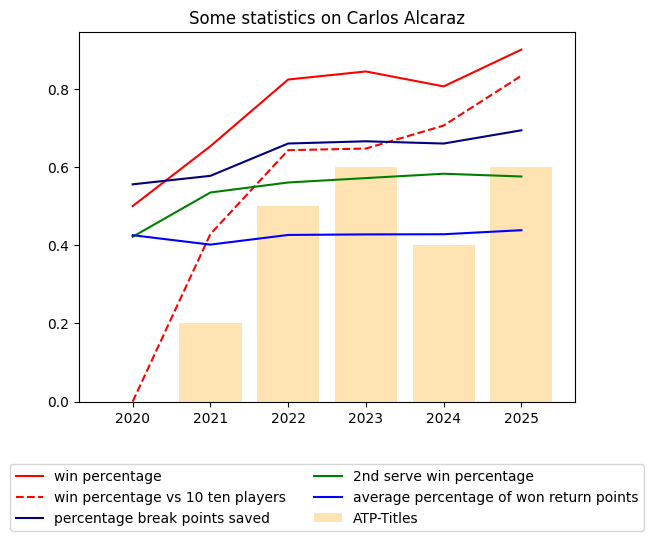

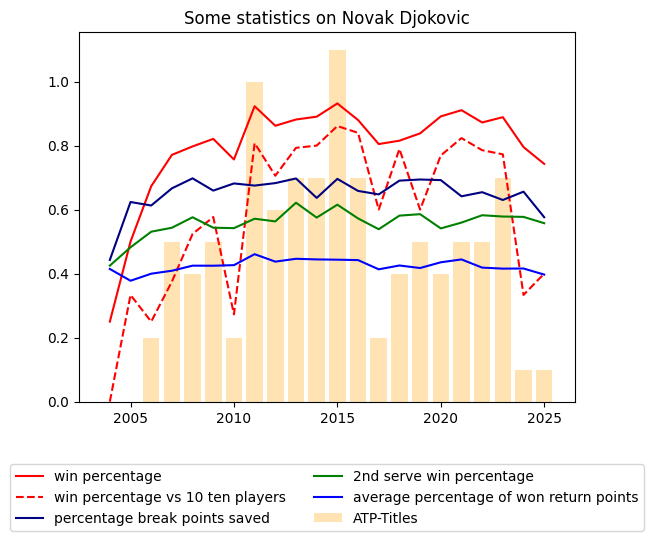

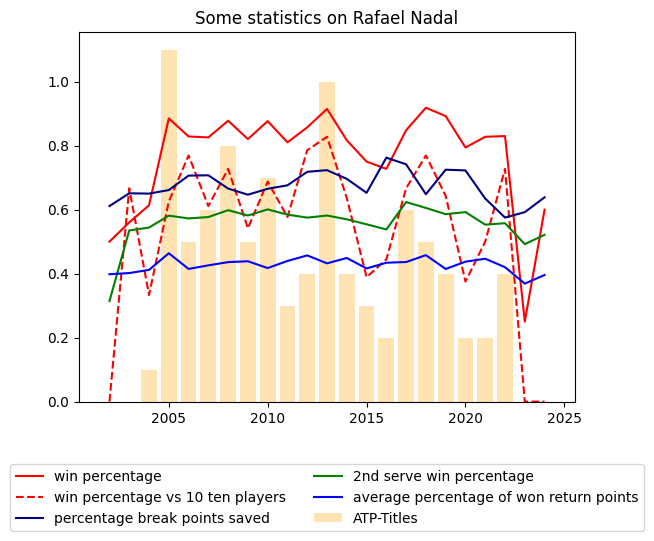

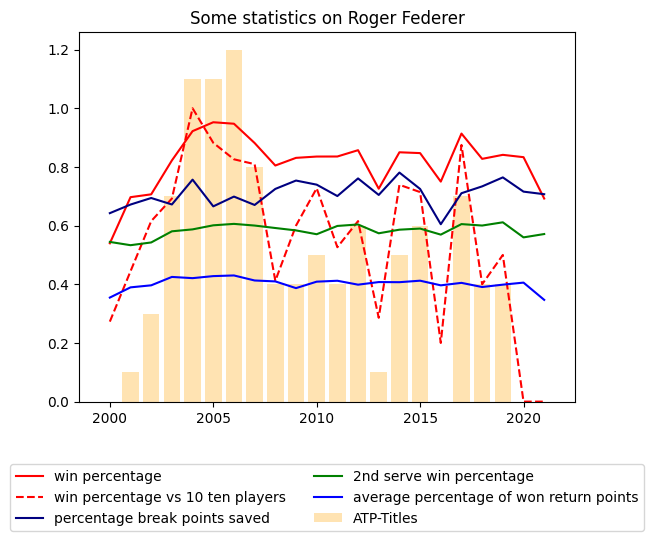

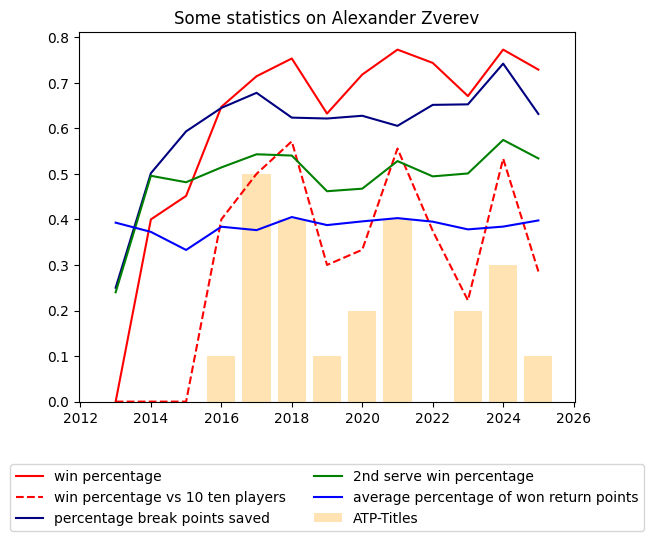

/var/folders/39/p2xs9v7547vfxg9djk82zf3c0000gn/T/ipykernel_25899/542252706.py:47: RuntimeWarning: invalid value encountered in divide
  player_df['2nd_serve_win_pc'] = second_won / (svpt - first_in)
/var/folders/39/p2xs9v7547vfxg9djk82zf3c0000gn/T/ipykernel_25899/542252706.py:53: RuntimeWarning: invalid value encountered in divide
  player_df['return_win_pc'] = (opp_svpt - opp_1st_won - opp_2nd_won) / opp_svpt


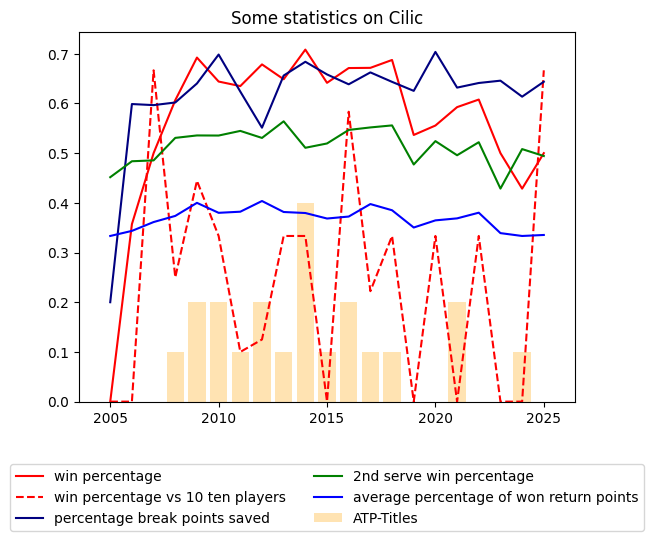

In [4]:
### Refactored yearly statistics for any player

# Choose player
player_list = ['Jannik Sinner', 'Carlos Alcaraz', 'Novak Djokovic', 'Rafael Nadal', 'Roger Federer', 'Alexander Zverev', 'Cilic']

for player in player_list:

    # Use a list of disctionaries to store results
    yearly_stats_list = []

    for year in range(2000,2026):
        #Load data and handle exception
        file_path = f'../tennis_data/ATP_data/{year}.csv'
        try:
            df = pd.read_csv(file_path)
        except FileNotFoundError:
            continue # Skip if the year's file doesn't exist

        #Clean data
        numeric_cols = ['w_ace', 'l_ace', 'w_df', 'l_df', 'w_bpSaved', 'l_bpSaved', 'w_bpFaced', 'l_bpFaced',
                        'w_1stIn', 'l_1stIn', 'w_1stWon', 'l_1stWon', 'w_2ndWon', 'l_2ndWon', 'w_svpt', 'l_svpt',
                        'winner_rank', 'loser_rank']
        for col in numeric_cols:
            df[col] = pd.to_numeric(df[col], errors='coerce')
        df.dropna(subset=numeric_cols, inplace=True) # Drop rows where essential stats are missing

        #Create unified data frame for Zverev
        player_df = df[df['winner_name'].str.contains(f'{player}', case=False, na=False) | 
                    df['loser_name'].str.contains(f'{player}', case=False, na=False)].copy()
        
        if player_df.empty:
            continue         #Skip year if no matches are recorded
        
        ### Create new columns
        player_df['is_win'] = np.where(player_df['winner_name'].str.contains(f'{player}', case=False, na=False), 1, 0)
        player_df['aces'] = np.where(player_df['is_win'] == 1, player_df['w_ace'], player_df['l_ace'])
        player_df['double_faults'] = np.where(player_df['is_win'] == 1, player_df['w_df'], player_df['l_df'])
        player_df['bp_saved'] = np.where(player_df['is_win'] == 1, player_df['w_bpSaved'], player_df['l_bpSaved'])
        player_df['bp_faced'] = np.where(player_df['is_win'] == 1, player_df['w_bpFaced'], player_df['l_bpFaced'])
        player_df['bp_ratio'] = np.where(player_df['bp_faced'] > 0, player_df['bp_saved']/player_df['bp_faced'], 1)
        player_df['opponent_rank'] = np.where(player_df['is_win'] == 1, player_df['loser_rank'], player_df['winner_rank'])
        
        # Second Serve Win %
        svpt = np.where(player_df['is_win'] == 1, player_df['w_svpt'], player_df['l_svpt'])
        first_in = np.where(player_df['is_win'] == 1, player_df['w_1stIn'], player_df['l_1stIn'])
        second_won = np.where(player_df['is_win'] == 1, player_df['w_2ndWon'], player_df['l_2ndWon'])
        player_df['2nd_serve_win_pc'] = second_won / (svpt - first_in)
        
        # Return Points Won %
        opp_svpt = np.where(player_df['is_win'] == 1, player_df['l_svpt'], player_df['w_svpt'])
        opp_1st_won = np.where(player_df['is_win'] == 1, player_df['l_1stWon'], player_df['w_1stWon'])
        opp_2nd_won = np.where(player_df['is_win'] == 1, player_df['l_2ndWon'], player_df['w_2ndWon'])
        player_df['return_win_pc'] = (opp_svpt - opp_1st_won - opp_2nd_won) / opp_svpt

        ### Calculate all aggregations from the clean DataFrame
        total_matches = len(player_df)
        win_percentage = player_df['is_win'].mean() # The mean of a 0/1 column is the percentage of 1s!
        titles = player_df[(player_df['is_win'] == 1) & (player_df['round'] == 'F')].shape[0]

        # vs. Top 10
        top10_matches_df = player_df[player_df['opponent_rank'] <= 10]
        win_percent_vs_top10 = top10_matches_df['is_win'].mean() if not top10_matches_df.empty else 0

        # Breakpoint save ratio
        bp_save_ratio = player_df['bp_ratio'].mean()

        # Store results
        yearly_stats_list.append({
            'year': year,
            'win_percentage': win_percentage,
            'win_percentage_vs_top10': win_percent_vs_top10,
            'avg_aces': player_df['aces'].mean(),
            'avg_double_faults': player_df['double_faults'].mean(),
            'break_point_save_ratio': bp_save_ratio,
            '2nd_serve_win_percentage': player_df['2nd_serve_win_pc'].mean(),
            'return_win_percentage': player_df['return_win_pc'].mean(),
            'ATP_titles': titles
        })

    ### Convert final list to a DataFrame for easy plotting
    stats_df = pd.DataFrame(yearly_stats_list)

    plt.plot(stats_df['year'], stats_df['win_percentage'], color = 'red', label = 'win percentage')
    plt.plot(stats_df['year'], stats_df['win_percentage_vs_top10'], color='red', linestyle = 'dashed', label = 'win percentage vs 10 ten players')
    plt.plot(stats_df['year'], stats_df['break_point_save_ratio'], color = 'navy', label = 'percentage break points saved')
    plt.plot(stats_df['year'], stats_df['2nd_serve_win_percentage'], color = 'green', label = '2nd serve win percentage')
    plt.plot(stats_df['year'], stats_df['return_win_percentage'], color = 'blue', label = 'average percentage of won return points')
    plt.bar(stats_df['year'], 0.1*stats_df['ATP_titles'], label='ATP-Titles', color='orange', alpha=0.3)
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2)
    plt.title(f'Some statistics on {player}')
    plt.show()

In [ ]:
# Correlation analysis

# Use a list of disctionaries to store results
yearly_stats_list = []

for year in range(2023,2024):
    #Load data and handle exception
    file_path = f'../tennis_data/ATP_data/{year}.csv'
    try:
        df = pd.read_csv(file_path)
    except FileNotFoundError:
        continue # Skip if the year's file doesn't exist

    #Clean data
    numeric_cols = ['w_ace', 'l_ace', 'w_df', 'l_df', 'w_bpSaved', 'l_bpSaved', 'w_bpFaced', 'l_bpFaced',
                    'w_1stIn', 'l_1stIn', 'w_1stWon', 'l_1stWon', 'w_2ndWon', 'l_2ndWon', 'w_svpt', 'l_svpt',
                    'winner_rank', 'loser_rank']
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col], errors='coerce')
    df.dropna(subset=numeric_cols, inplace=True) # Drop rows where essential stats are missing

    # Limit analysis on Grand Slam matches
    grandslam_mask = (df['tourney_level'] == 'G')
    df = df[grandslam_mask]

    # Filter out non completed matches
    abandonment_mask = (df['score'].str.contains('RET') | df['score'].str.contains('DEF'))
    df = df[~abandonment_mask]

    # Create new columns for data frame

    winner_sets_list = []
    loser_sets_list = []
    set_diff_list = []
    rank_diff_list = []
    rank_points_diff_list = []

    for index,match in df.iterrows():
        # Add set counter for both players
        sets_score=match['score'].split(' ')
        winner_sets = 0
        loser_sets = 0
        for set_score in sets_score:
            games = set_score.split('-')
            # Handle tie-break notation
            try:
                if int(games[0]) == 7:
                    games[1] = games[1].split('(')[0]
            except: 
                pass
            try:
                if int(games[1]) == 7:
                    games[0] = games[0].split('(')[0]
            except:
                pass

            try:
                if games[0] > games[1]:
                    winner_sets += 1
                else:
                    loser_sets +=1
            except:
                print(f'error in row {index}')
        winner_sets_list.append(winner_sets)
        loser_sets_list.append(loser_sets)
        set_diff_list.append(winner_sets - loser_sets)

        # Add rank difference feature
            
        rank_diff = int(match['winner_rank']) - int(match['loser_rank'])
        rank_diff_list.append(rank_diff)
        rank_points_diff = int(match['winner_rank_points']) - int(match['loser_rank_points'])
        rank_points_diff_list.append(rank_points_diff)
    
    new_stats = {
        'winner_sets': np.array(winner_sets_list),
        'loser_sets': np.array(loser_sets_list),
        'set_diff': np.array(set_diff_list),
        'rank_diff': np.array(rank_diff_list),
        'rank_points_diff': np.array(rank_points_diff_list)
    }

# normalize new stats:
rank_diff_max_abs = np.max(np.abs(new_stats['rank_diff']))
new_stats['rank_diff'] = new_stats['rank_diff']* 1/(rank_diff_max_abs)

rank_points_diff_max_abs = np.max(np.abs(new_stats['rank_points_diff']))
new_stats['rank_points_diff'] = new_stats['rank_points_diff']* 1/(rank_points_diff_max_abs)



df = df.join(pd.DataFrame(new_stats, index=df.index))

array([2, 1, 3])

The average normalized rank differences for a 1,2 or 3 set difference victory respectively are (0.015470888063018336, -0.030418293425381344, -0.057064571475493445).


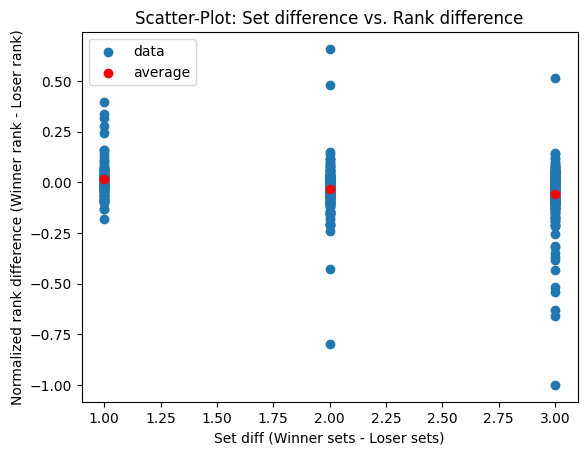

The average normalized rank point differences for a 1,2 or 3 set difference victory respectively are (0.007156989463204877, 0.10342995921009396, 0.17432953487527408).


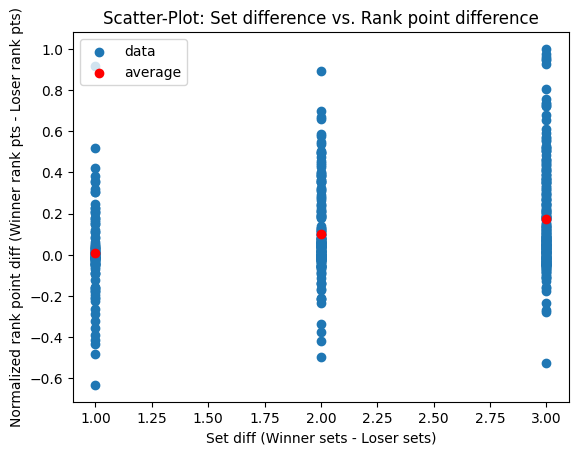

In [152]:
mask1 = ((df['set_diff']) == 1)
mask2 = ((df['set_diff']) == 2)
mask3 = ((df['set_diff']) == 3)

avg1 = df[mask1]['rank_diff'].mean()
avg2 = df[mask2]['rank_diff'].mean()
avg3 = df[mask3]['rank_diff'].mean()

print(f'The average normalized rank differences for a 1,2 or 3 set difference victory respectively are {avg1, avg2, avg3}.')

plt.scatter(df['set_diff'], df['rank_diff'], label='data')
plt.scatter([1,2,3], [avg1,avg2,avg3], color = 'red', label='average')
plt.title('Scatter-Plot: Set difference vs. Rank difference')
plt.xlabel('Set diff (Winner sets - Loser sets)')
plt.ylabel('Normalized rank difference (Winner rank - Loser rank)')
plt.legend()
plt.show()

avg1 = df[mask1]['rank_points_diff'].mean()
avg2 = df[mask2]['rank_points_diff'].mean()
avg3 = df[mask3]['rank_points_diff'].mean()

print(f'The average normalized rank point differences for a 1,2 or 3 set difference victory respectively are {avg1, avg2, avg3}.')

plt.scatter(df['set_diff'], df['rank_points_diff'], label='data')
plt.scatter([1,2,3], [avg1,avg2,avg3], color = 'red', label='average')
plt.title('Scatter-Plot: Set difference vs. Rank point difference')
plt.xlabel('Set diff (Winner sets - Loser sets)')
plt.ylabel('Normalized rank point diff (Winner rank pts - Loser rank pts)')
plt.legend()
plt.show()

In [ ]:
### We conclude that rank difference is not as conclusive as one might think for predicting winners / the "magnitude" of the win measured by the set difference.
### In the case of the matches won with a 1 set margine there is even a slight tendency favoring the underdog by rank.

### Rank points on the other hand seem to be more conclusive with a clear tendency to favor a higher win margine the greater the rank points difference is.
### Nevertheless the signal is far from being considered strong.

# Overall ranking points seem to contain a good chunk of information on the outcome of matches but especially for close matchup's (which are represented by
# the smallest win margine) rank seems to become more and more irrelevant. 
# It is reasoable to expect that finding metrics that predict these close match ups well will be a key to build a model with significant predictive power.